In [458]:
#DATA READING, CLEANING, AND PRE-PROCESSING#

In [459]:
import shapely                
from shapely.wkt import loads
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import pysal
import libpysal
from spreg import OLS
import statsmodels.api as sm
import os
import urllib
import zipfile
import re
from descartes import PolygonPatch
from libpysal.weights.contiguity import Queen
from pysal.model import mgwr
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
warnings.filterwarnings("ignore")

In [460]:
english_proficiency = pd.read_csv(os.path.join('English Proficiency.csv'))

In [461]:
qualifications = pd.read_csv(os.path.join('Qualifications.csv'))

In [462]:
household_composition = pd.read_csv(os.path.join('Household composition.csv'))

In [463]:
country_birth = pd.read_csv(os.path.join('Country of birth.csv'))

In [464]:
age_arrival = pd.read_csv(os.path.join('Age on arrival in UK.csv'))

In [465]:
lsoas = pd.read_csv(os.path.join('LSOA_Data_2011.csv'))

In [466]:
lsoas = gpd.GeoDataFrame(lsoas)
lsoas['geometry'] = lsoas['geometry'].apply(lambda x: loads(x))
lsoas = lsoas.set_geometry('geometry')

In [467]:
lsoas['Prop Black']= lsoas['Black']/lsoas['USUALRES']

In [468]:
cols1 =['LSOA code', 'Usual residents aged 3+', 'Main language is English',
       'Language not English: Speak English very well',
       'Language not English: Speak English well',
       'Language not English: Cannot speak English well',
       'Language not English: Cannot speak English']
english_proficiency_cleaned = english_proficiency[cols1]

In [469]:
english_proficiency_cleaned['Poor English Proficiency']= english_proficiency_cleaned['Language not English: Cannot speak English well'] 
+ english_proficiency_cleaned['Language not English: Cannot speak English']

0        0
1        1
2        2
3        8
4        0
        ..
4989     1
4990     5
4991     1
4992    15
4993     6
Name: Language not English: Cannot speak English, Length: 4994, dtype: int64

In [470]:
english_proficiency_cleaned['Prop Poor English Proficiency']= english_proficiency_cleaned['Poor English Proficiency'] /english_proficiency_cleaned['Usual residents aged 3+']

In [471]:
english_proficiency_cleaned['Prop Poor English Proficiency']

0       0.002089
1       0.004317
2       0.011468
3       0.054054
4       0.004845
          ...   
4989    0.013712
4990    0.020619
4991    0.021415
4992    0.032762
4993    0.014818
Name: Prop Poor English Proficiency, Length: 4994, dtype: float64

In [472]:
cols2 =['LSOA code', 'All households', 'One person Aged 65+', 'One person Aged up to 64',
       'Family: all aged 65+',
       'Married or civil partnership couple: No children',
       'Married or civil partnership couple: Dependent children',
       'Married or civil partnership couple: non-dependent children',
       'Cohabiting couple: No children',
       'Cohabiting couple: Dependent children',
       'Cohabiting couple: Non-dependent children',
       'Lone parent: dependent children',
       'Lone parent: non-dependent children', 'Other with dependent children',
       'All other types', 'Unnamed: 17']
household_composition_cleaned = household_composition[cols2]

In [473]:
household_composition_cleaned['Prop Lone Parent: Dependent Children']= household_composition_cleaned['Lone parent: dependent children'] /household_composition_cleaned['All households']

In [474]:
household_composition_cleaned['Prop Lone Parent: Dependent Children']

0       0.010274
1       0.015663
2       0.040392
3       0.059957
4       0.011834
          ...   
4989    0.024096
4990    0.033510
4991    0.066308
4992    0.056005
4993    0.013756
Name: Prop Lone Parent: Dependent Children, Length: 4994, dtype: float64

In [475]:
cols3 =['LSOA code', 'Usual residents aged 16+', 'none', 'Level 1', 'Level 2',
       'Apprentice-ship', 'Level 3', 'Level 4+', 'Other']
qualifications_cleaned = qualifications[cols3]

In [476]:
qualifications_cleaned['Level 2+ Attainment']= qualifications_cleaned['Level 2']+ qualifications_cleaned['Level 2']
+ qualifications_cleaned['Level 3']+ qualifications_cleaned['Level 4+']

0       1141
1       1115
2        799
3        361
4        546
        ... 
4989    2071
4990     620
4991     593
4992    1243
4993    1808
Length: 4994, dtype: int64

In [477]:
qualifications_cleaned['Prop Level 2 Attainment'] = qualifications_cleaned['Level 2+ Attainment']/qualifications_cleaned [ 'Usual residents aged 16+']

In [478]:
qualifications_cleaned['Prop Level 2 Attainment']

0       0.111111
1       0.109822
2       0.178744
3       0.224117
4       0.258212
          ...   
4989    0.160528
4990    0.125413
4991    0.164882
4992    0.222982
4993    0.131737
Name: Prop Level 2 Attainment, Length: 4994, dtype: float64

In [479]:
cols4 =['LSOA code', 'All Usual residents', 'United Kingdom', 'European Union EU14', 'Other EU countries',
         'non-EU Europe','Africa','Middle East and Asia', 'Americas and Caribbean',
         'Australasia, other Oceania and Other including British Overseas Territories']
country_birth_cleaned = country_birth[cols4]

In [480]:
country_birth_cleaned['Prop non-EU Europe']= country_birth_cleaned['non-EU Europe']/ country_birth_cleaned['All Usual residents']

In [481]:
country_birth_cleaned['Prop non-EU Europe']

0       0.021160
1       0.018802
2       0.023774
3       0.014213
4       0.040230
          ...   
4989    0.043548
4990    0.066066
4991    0.034978
4992    0.036082
4993    0.031493
Name: Prop non-EU Europe, Length: 4994, dtype: float64

In [482]:
cols5 = ['LSOA code', 'All usual residents', 'Born in the UK', 'Aged 0 to 4', 'Aged 5 to 7', 
         'Aged 8 to 9',	'Aged 10 to 14', 'Aged 15 ', 'Aged 16 to 17','Aged 18 to 19', 
         'Aged 20 to 24', 'Aged 25 to 29',	'Aged 30 to 44', 'Aged 45 to 59','Aged 60 to 64',
         'Aged 65 to 74', 'Aged 75 to 84','Aged 85 to 89', 'Aged 90 or over']
age_arrival_cleaned = age_arrival[cols5]

In [483]:
step_one = english_proficiency_cleaned.merge(household_composition_cleaned, left_on="LSOA code", right_on="LSOA code", how='inner')

In [484]:
step_two = step_one.merge(qualifications_cleaned, left_on="LSOA code", right_on="LSOA code", how='inner')

In [485]:
step_three =step_two.merge(country_birth_cleaned, left_on="LSOA code", right_on="LSOA code", how='inner')

In [486]:
step_four = step_three.merge(age_arrival_cleaned, left_on="LSOA code", right_on="LSOA code", how='inner')

In [487]:
my_df = pd.merge(lsoas, step_four, left_on='LSOA11CD', right_on='LSOA code')

In [488]:
#VIF 'Lone parent: dependent children'
y = my_df['Level 2']
X = my_df[['HHI_mean','Black','Language not English: Cannot speak English','Lone parent: dependent children']]

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,2.394844,HHI_mean
1,5.833285,Black
2,2.011920,Language not English: Cannot speak English
3,7.526407,Lone parent: dependent children


In [489]:
#VIF Prop Lone Parent:Dependent Children
y = my_df['Prop Level 2 Attainment']
X = my_df[['HHI_mean','Prop Black','Prop Poor English Proficiency','Prop Lone Parent: Dependent Children',]]

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,2.439930,HHI_mean
1,5.688509,Prop Black
2,2.786947,Prop Poor English Proficiency
3,7.537438,Prop Lone Parent: Dependent Children


In [490]:
#VIF Age on Arrival to the UK
y = my_df['Prop Level 2 Attainment']
X = my_df[['HHI_mean','Prop Black','Prop Poor English Proficiency','Aged 0 to 4', 'Aged 5 to 7', 
         'Aged 8 to 9',	'Aged 10 to 14', 'Aged 15 ', 'Aged 16 to 17',]]

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,5.819805,HHI_mean
1,3.059261,Prop Black
2,7.892855,Prop Poor English Proficiency
3,21.507894,Aged 0 to 4
4,20.739414,Aged 5 to 7
5,15.930159,Aged 8 to 9
6,26.897536,Aged 10 to 14
7,10.127565,Aged 15
8,11.691229,Aged 16 to 17


In [491]:
#VIF Country of Birth

y = my_df['Prop Level 2 Attainment']
X = my_df[['HHI_mean','Prop Black','Prop Poor English Proficiency','European Union EU14', 'Other EU countries',
         'non-EU Europe','Africa','Middle East and Asia', 'Americas and Caribbean',
         'Australasia, other Oceania and Other including British Overseas Territories',]]

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,6.079959,HHI_mean
1,12.996206,Prop Black
2,11.452280,Prop Poor English Proficiency
3,13.578975,European Union EU14
4,3.741417,Other EU countries
5,3.346978,non-EU Europe
6,12.931350,Africa
7,7.682976,Middle East and Asia
8,10.544265,Americas and Caribbean
9,3.859570,"Australasia, other Oceania and Other including..."


In [492]:
#VIF Country of Birth

y = my_df['Prop Level 2 Attainment']
X = my_df[['HHI_mean','Prop Black','Prop Poor English Proficiency', 'Prop non-EU Europe']]

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif

,VIF,variable
0,2.338883,HHI_mean
1,2.559010,Prop Black
2,2.903172,Prop Poor English Proficiency
3,2.562604,Prop non-EU Europe


In [361]:
#CORRELATION MATRIX#

In [494]:
corr_data = my_df.drop(['LSOA11CD', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM',
       'RGN11CD', 'RGN11NM', 'geometry', 'USUALRES', 'HHOLDRES', 'COMESTRES',
       'POPDEN', 'HHOLDS', 'AVHHOLDSZ', 'RoadsArea', 'White', 'MultiEthnic',
       'Asian', 'OtherEthnic', 'Area', 'HHI_median',
       'gas_meters', 'gas_total', 'gas_mean', 'gas_median', 'elec_meters',
       'elec_total', 'elec_mean', 'elec_median', 'LSOA code',
       'Usual residents aged 3+', 'Main language is English',
       'Language not English: Speak English very well',
       'Language not English: Speak English well',
       'Language not English: Cannot speak English well', 'All households',
       'One person Aged 65+', 'One person Aged up to 64',
       'Family: all aged 65+',
       'Married or civil partnership couple: No children',
       'Married or civil partnership couple: Dependent children',
       'Married or civil partnership couple: non-dependent children',
       'Cohabiting couple: No children',
       'Cohabiting couple: Dependent children',
       'Cohabiting couple: Non-dependent children',
       'Lone parent: non-dependent children', 'Other with dependent children',
       'All other types', 'Unnamed: 17', 'Usual residents aged 16+', 'none',
       'Level 1', 'Level 2', 'Apprentice-ship', 'Level 3', 'Level 4+',
       'Other',  'All usual residents', 'Born in the UK', 'Aged 0 to 4', 'Aged 5 to 7', 
         'Aged 8 to 9',	'Aged 10 to 14', 'Aged 15 ', 'Aged 16 to 17','Aged 18 to 19', 
         'Aged 20 to 24', 'Aged 25 to 29',	'Aged 30 to 44', 'Aged 45 to 59','Aged 60 to 64',
         'Aged 65 to 74', 'Aged 75 to 84','Aged 85 to 89', 'Aged 90 or over', 
        'All Usual residents', 'United Kingdom', 'European Union EU14','Africa',
        'Middle East and Asia', 'Americas and Caribbean', 'Other EU countries',
         'Australasia, other Oceania and Other including British Overseas Territories'], axis=1)

In [495]:
corr= corr_data.corr()

In [496]:
corr.style.background_gradient(cmap='coolwarm')

,Black,HHI_mean,Prop Black,Language not English: Cannot speak English,Poor English Proficiency,Prop Poor English Proficiency,Lone parent: dependent children,Prop Lone Parent: Dependent Children,Level 2+ Attainment,Prop Level 2 Attainment,non-EU Europe,Prop non-EU Europe
Black,1.000000,-0.490891,0.974328,0.329946,0.416988,0.403813,0.766078,0.731835,0.160370,0.089142,0.305170,0.261208
HHI_mean,-0.490891,1.000000,-0.497592,-0.370546,-0.418696,-0.428719,-0.529618,-0.587643,-0.452072,-0.458829,0.016975,0.050309
Prop Black,0.974328,-0.497592,1.000000,0.282546,0.362813,0.384493,0.736826,0.752171,0.095527,0.107417,0.276354,0.262311
Language not English: Cannot speak English,0.329946,-0.370546,0.282546,1.000000,0.884708,0.860248,0.228040,0.237195,-0.013445,-0.154725,0.270903,0.223418
Poor English Proficiency,0.416988,-0.418696,0.362813,0.884708,1.000000,0.974561,0.300687,0.304576,-0.003733,-0.166859,0.347760,0.292745
Prop Poor English Proficiency,0.403813,-0.428719,0.384493,0.860248,0.974561,1.000000,0.276682,0.325409,-0.084339,-0.166671,0.341737,0.318738
Lone parent: dependent children,0.766078,-0.529618,0.736826,0.228040,0.300687,0.276682,1.000000,0.940977,0.286677,0.231327,0.357591,0.305758
Prop Lone Parent: Dependent Children,0.731835,-0.587643,0.752171,0.237195,0.304576,0.325409,0.940977,1.000000,0.247955,0.319970,0.282468,0.268378
Level 2+ Attainment,0.160370,-0.452072,0.095527,-0.013445,-0.003733,-0.084339,0.286677,0.247955,1.000000,0.864141,-0.155755,-0.238093
Prop Level 2 Attainment,0.089142,-0.458829,0.107417,-0.154725,-0.166859,-0.166671,0.231327,0.319970,0.864141,1.000000,-0.247361,-0.260077


In [497]:
#OLS REGRESSION

In [498]:
x = ['HHI_mean','Prop Black','Prop Poor English Proficiency','Prop non-EU Europe']
X = my_df.loc[:, x].dropna()
X = sm.add_constant(X)
y = np.array(my_df['Prop Level 2 Attainment'])

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     718.1
Date:                Tue, 16 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:38:37   Log-Likelihood:                 6870.6
No. Observations:                4659   AIC:                        -1.373e+04
Df Residuals:                    4654   BIC:                        -1.370e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [499]:
#GWR MODEL

In [500]:
my_df['Center_point'] = my_df['geometry'].centroid

#Extract lat and lon from the centerpoint
my_df["X"] = my_df.Center_point.map(lambda p: p.x)
my_df["Y"] = my_df.Center_point.map(lambda p: p.y)

In [501]:
g_y = my_df['Prop Level 2 Attainment'].values.reshape((-1,1))

g_X = my_df[['HHI_mean', 'Prop Black', 'Prop Poor English Proficiency','Prop non-EU Europe']].values

u = my_df['X']
v = my_df['Y']

g_coords = list(zip(u,v))

g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [502]:
bw = mgwr.sel_bw.Sel_BW(g_coords, 
                  g_y,
                  g_X,
                  fixed=False,
                  spherical=False)

In [503]:
bw.search()

71.0

In [504]:
#WEIGHT MATRIX#

In [505]:
wq = Queen.from_dataframe(my_df)
wq

In [506]:
model = mgwr.gwr.GWR(g_coords,
                     g_y,
                     g_X,
                     bw.bw[0])

In [507]:
results = model.fit()
results.summary()

Model type                                                         Gaussian
Number of observations:                                                4659
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           2880.882
Log-likelihood:                                                   -5491.034
AIC:                                                              10992.067
AICc:                                                             10994.085
BIC:                                                             -36429.390
R2:                                                                   0.382
Adj. R2:                                                              0.381

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [508]:
#MODEL PERFORMANCE

In [509]:
data_all = pd.DataFrame(results.params)
localR2=pd.DataFrame(results.localR2)

In [510]:
df1=pd.DataFrame(my_df["LSOA11CD"])
df2 = df1.assign(intercept=data_all[0],
                 HHI_mean=data_all[1],
                 Black=data_all[2],
                 cannot_speak_english=data_all[3],
                 lone_parent=data_all[4],
                 
                 localR2=localR2[0])
df2.columns

Index(['LSOA11CD', 'intercept', 'HHI_mean', 'Black', 'cannot_speak_english',
       'lone_parent', 'localR2'],
      dtype='object')

In [511]:
#COMPARING MODELS

In [512]:
filtered_estimates = results.filter_tvals(alpha=.05)
filtered_estimates

filtered_estimates90 = results.filter_tvals(alpha=.1)
filtered_estimates99 = results.filter_tvals(alpha=.01)

In [513]:
#VISUALISING

In [514]:
data_params = pd.DataFrame(filtered_estimates)
data_localR2 = pd.DataFrame(results.localR2)

In [515]:
df1=pd.DataFrame(my_df["LSOA11CD"])
results_gdf= df1.assign(intercept=data_params[0],
                 HHI_mean=data_params[1],
                 Black=data_params[2],
                 cannot_speak_english=data_params[3],
                 lone_parent=data_params[4],
                 localR2=data_localR2[0])

In [516]:
my_df = my_df.merge(results_gdf, left_on='LSOA11CD', right_on='LSOA11CD')

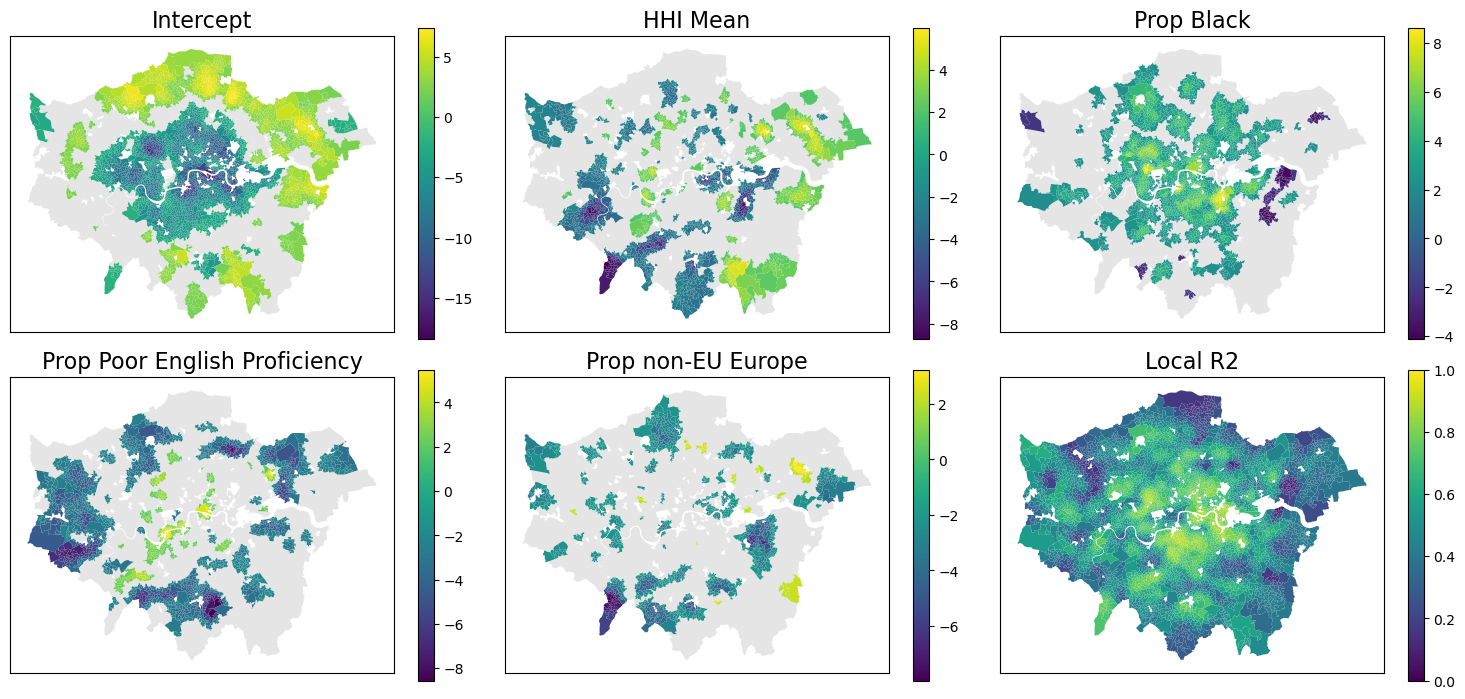

In [517]:
f,ax=plt.subplots(2,3,figsize=(15,7), subplot_kw=dict(aspect='equal'))
ax = ax.flatten()
titles = ['Intercept','HHI Mean', 'Prop Black', 'Prop Poor English Proficiency', 'Prop non-EU Europe']

for i,row in enumerate(filtered_estimates.T):
    my_df_temp = my_df.assign(toplot=filtered_estimates.T[i])
    (my_df_temp.query('toplot==0')
     .sort_values('toplot')
     .plot(color='grey',ax=ax[i],alpha=.2))
    (my_df_temp.query('toplot!=0')
     .sort_values('toplot')
     .plot('toplot',
           cmap='viridis',
           ax=ax[i],
           legend=True))
    
    ax[i].set_title(titles[i], fontsize=16)
    
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

(my_df.assign(r2=results.localR2)
 .sort_values('r2')
 .plot('r2',
       ax=ax[-1],
       legend=True,
       vmin=0,
       vmax=1,
       cmap='viridis'))
    
ax[-1].set_xticklabels([])
ax[-1].set_yticklabels([])
ax[-1].set_xticks([])
ax[-1].set_yticks([])
    
ax[-1].set_title('Local R2', fontsize=16)
    
f.tight_layout()

plt.show()